# Survival *lifelines*
[https://lifelines.readthedocs.io/](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_files = pd.read_csv("datasets/cancers/lung/files.txt", sep="\t").dropna(how="all", thresh=300, axis=1)
df_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 14 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   cases.0.demographic.days_to_birth              1098 non-null   float64
 1   cases.0.demographic.days_to_death              456 non-null    float64
 2   cases.0.demographic.gender                     1145 non-null   object 
 3   cases.0.demographic.vital_status               1145 non-null   object 
 4   cases.0.diagnoses.0.age_at_diagnosis           1098 non-null   float64
 5   cases.0.diagnoses.0.days_to_last_follow_up     869 non-null    float64
 6   cases.0.diagnoses.0.last_known_disease_status  1145 non-null   object 
 7   cases.0.diagnoses.0.tumor_stage                1145 non-null   object 
 8   cases.0.exposures.0.cigarettes_per_day         867 non-null    float64
 9   cases.0.exposures.0.years_smoked               467 n

In [3]:
df_files["cases.0.diagnoses.0.last_known_disease_status"].unique()

array(['not reported'], dtype=object)

In [4]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].mean()
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

In [5]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

In [6]:
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage iii', 'stage i', 'stage ii', 'stage iv', 'not reported'],
      dtype=object)

In [7]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

In [8]:
#1 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

['not reported']


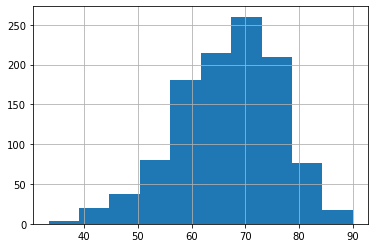

In [9]:
print(df_files["cases.0.diagnoses.0.last_known_disease_status"].unique())
(df_files["cases.0.diagnoses.0.age_at_diagnosis"]/365).hist()

In [10]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

In [11]:
bins = np.linspace(0,100,10)
df_files["smoke"] = pd.cut(df_files["cases.0.exposures.0.years_smoked"], bins=bins, labels = (bins[1:]+bins[:-1])/2 ).__array__()
df_files["smoke"].fillna(0, inplace=True)

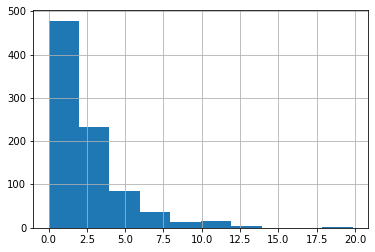

In [12]:
(df_files["days_survival"]/365).hist()

In [13]:
subset = df_files[~df_files["days_survival"].isna()].sample(80)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


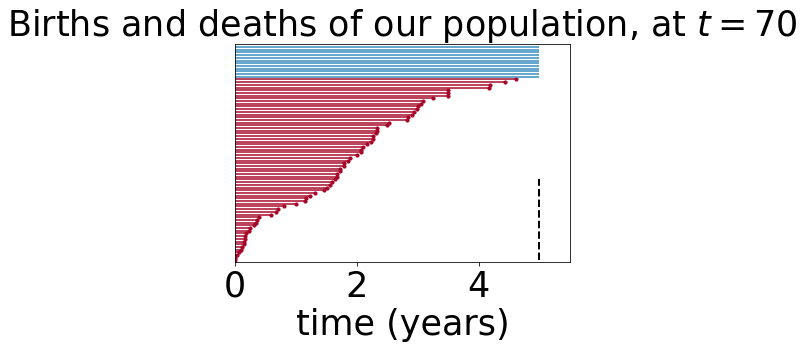

In [14]:
from lifelines.plotting import plot_lifetimes

CURRENT_TIME = 5

actual_lifetimes = subset["days_survival"].to_numpy()/365
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, figsize=(18,15))

ax.set_xlim(0, CURRENT_TIME*1.1)
ax.vlines(CURRENT_TIME, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time (years)", fontsize=35)
ax.tick_params(labelsize=35)
ax.set_title("Births and deaths of our population, at $t=70$", fontsize=35)
plt.tight_layout()
#print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

In [15]:
subset = df_files[~df_files["days_survival"].isna()]
data = {}
data["duration"]=subset["days_survival"]/365
data["observed"]=subset["vital_status"]
data["entry"]=subset["cases.0.demographic.days_to_birth"]/365

In [16]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [17]:
df_files["vital_status"].sum()

465

In [18]:
T = data["duration"]
E = data["observed"]
entry = data["entry"]

(0.0, 15.0)

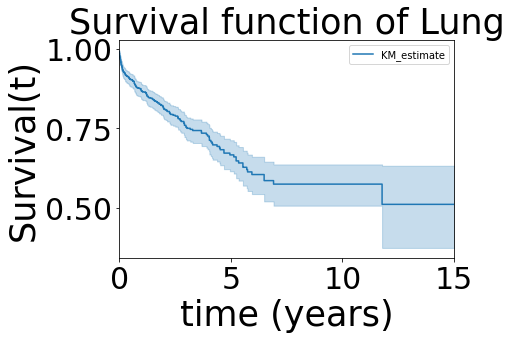

In [19]:
kmf.fit(T, event_observed=E)
ax = kmf.plot()

ax.set_title('Survival function of Lung', fontsize=35)
ax.set_xlabel("time (years)", fontsize=35)
ax.set_ylabel("Survival(t)", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xlim(0,15)

In [20]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
print(kmf.median_survival_time_, "+-", median_ci)

inf +-      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5               11.778082                     inf


Text(0.5, 1.0, 'Survival of different cancer types')

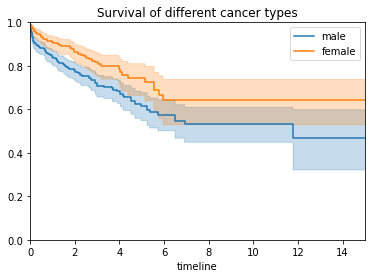

In [21]:
ax = plt.subplot(111)

mask = (subset["cases.0.demographic.gender"]=="male")

kmf.fit(T[mask], event_observed=E[mask], label="male")
kmf.plot(ax=ax)

kmf.fit(T[~mask], event_observed=E[~mask], label="female")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlim(0,15)
plt.title("Survival of different cancer types")

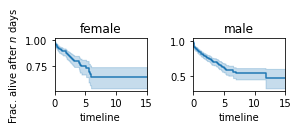

In [22]:
key = 'cases.0.demographic.gender'
labels = subset[key].unique()

for i, label in enumerate(np.sort(labels)):
    ax = plt.subplot(3, 3, i + 1)

    ix = subset[key] == label
    kmf.fit(T[ix], E[ix], label=label)
    kmf.plot(ax=ax, legend=False)

    plt.title(label)
    plt.xlim(0, 15)

    if i==0:
        plt.ylabel('Frac. alive after $n$ days')

plt.tight_layout()

In [28]:
import importlib, survival
importlib.reload(survival)
from survival import fit_cox, add_group_to_subset

In [50]:
df_clusters = pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
df_clusters = pd.read_csv("datasets/cancers/lung/lda/lda_level_2_topic-dist.csv",index_col=1).drop("i_doc",1)

Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
<class 'lifelines.utils.ConvergenceError'> delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model <traceback object at 0x7f3f5f7fc550>


/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1095: ConvergenceWarning: Column(s) ['group'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:615: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)


Too low -log2(p): -0.0
Too low -log2(p): -0.0
<class 'lifelines.utils.ConvergenceError'> delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model <traceback object at 0x7f3f5f7f8d20>


/opt/conda/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:794: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/opt/conda/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:615: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1115: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logis

Too low -log2(p): -0.0
Too low -log2(p): -0.0
<class 'lifelines.utils.ConvergenceError'> delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model <traceback object at 0x7f3f5f8c12d0>


/opt/conda/lib/python3.7/site-packages/lifelines/utils/__init__.py:1095: ConvergenceWarning: Column(s) ['group'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:615: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)


Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
TCGA-LUAD :  Topic 21 
 coef    0.485626
p       0.072614
Name: Topic_21, dtype: float64 

Too low -log2(p): -0.0
Too low -log2(p): -0.0
TCGA-LUAD :  Topic 24 
 coef    0.434959
p       0.123200
Name: Topic_24, dtype: float64 

Too low -log2(p): 0.37526636778492334
Too low -log2(p): -0.0
Too low -log2(p): 0.09536961695649601
Too low -log2(p): -0.0
Too low -log2(p): -0.0
TCGA-LUSC :  Topic 4 
 coef   -0.537070
p       0.082145
Name: Topic_4, dtype: float64 

Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): 0.5155327671732912
Too low -log2(p): -0.0
TCGA-LUSC :  Topic

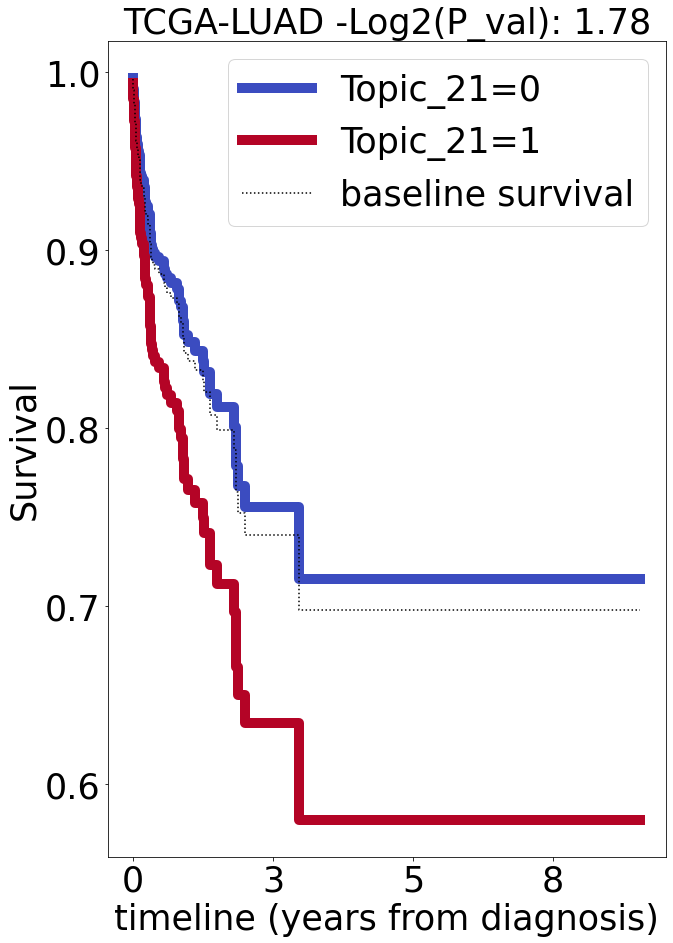

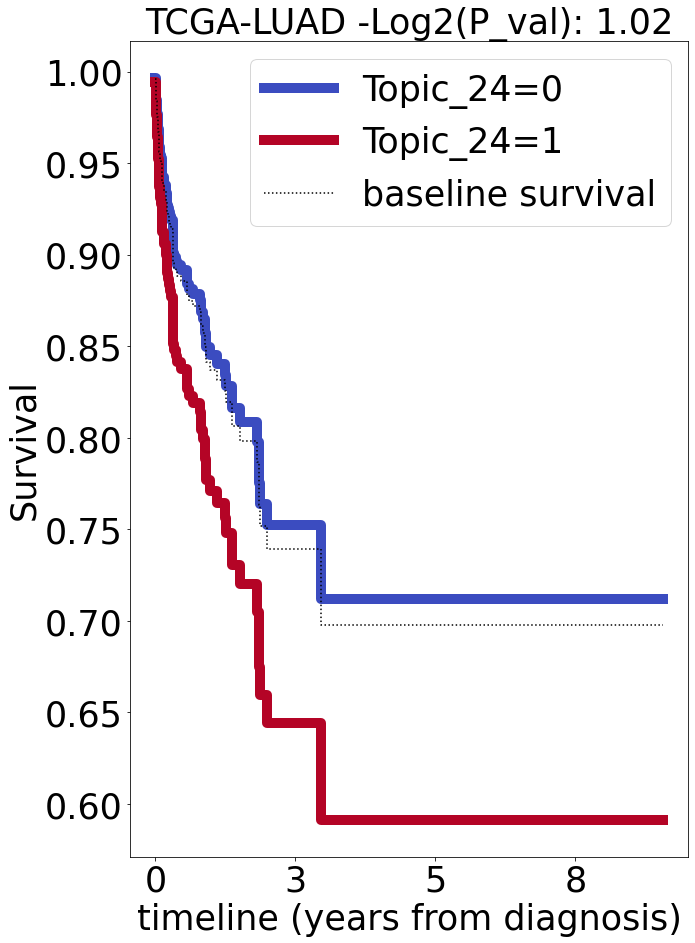

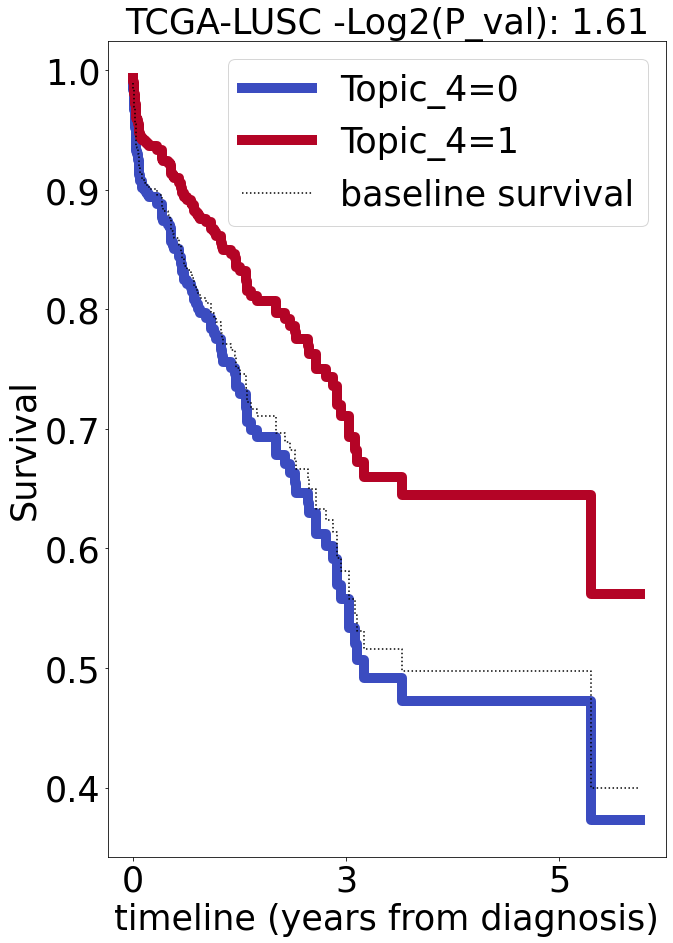

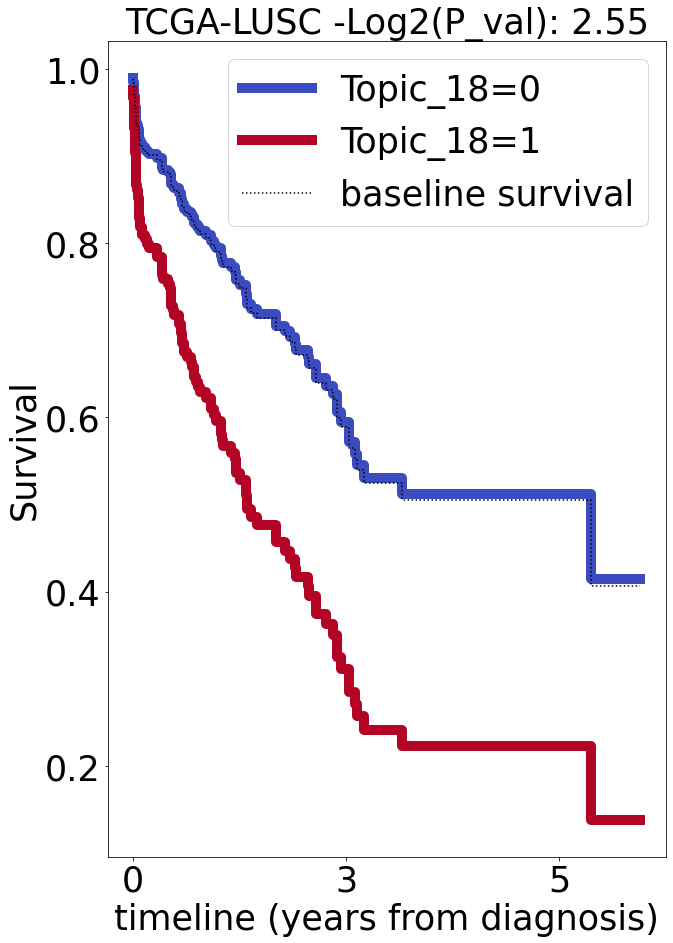

In [53]:
for dataset in ["TCGA-LUAD", "TCGA-LUSC"]:
    mask = (~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported") & (df_files["cases.0.project.project_id"]==dataset)
    subset = df_files[mask]
    subset=subset.set_index("file_name")
    subset = subset[["days_survival","vital_status","gender", "tumor_stage", "age_at_diagnosis"]]
    for topic in df_clusters.columns:
        top_set = add_group_to_subset(topic, subset, df_clusters)
        summary, _, ax = fit_cox(top_set, topic)
        if summary is not None:
            if summary.at[summary.index[-1],"-log2(p)"] > 3:
                print(dataset,": ",topic,"\n",summary.loc[summary.index[-1],["coef", "p"]],"\n")
        if ax is not None:
            ax.set_title(dataset+" "+ax.title.get_text(), fontsize=35)

In [48]:
summary, _, ax = fit_cox(top_set, "Topic 2")
summary

Too low -log2(p): -0.0


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),corrected_p,-log2(corrected_p)
gender,0.369727,1.447340,0.224621,-0.070523,0.809977,0.931907,2.247856,1.646002,0.099763,3.325347,0.399053,1.325347
tumor_stage,0.251800,1.286339,0.119288,0.018000,0.485601,1.018163,1.625151,2.110858,0.034784,4.845413,0.139138,2.845413
age_at_diagnosis,0.032378,1.032908,0.011788,0.009274,0.055482,1.009317,1.057050,2.746696,0.006020,7.376048,0.024080,5.376048
Topic_2,-0.036482,0.964175,0.258862,-0.543843,0.470878,0.580513,1.601400,-0.140933,0.887923,0.171494,1.000000,-0.000000


In [58]:
for g in pd.read_csv("datasets/cancers/lung/lda/lda_level_2_topics.csv",index_col=1)["Topic 18"].values:
    print(g[:15])

ENSG00000269981
ENSG00000185619
ENSG00000139329
ENSG00000127399
ENSG00000127329
ENSG00000116741
ENSG00000125740
ENSG00000090339
ENSG00000163251
ENSG00000163406
ENSG00000099998
ENSG00000163141
ENSG00000138207
ENSG00000008853
ENSG00000270157
ENSG00000136379
ENSG00000102575
ENSG00000076641
ENSG00000227671
ENSG00000074527
ENSG00000136167


In [ ]:
(pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topics.csv",index_col=1)=="ENSG00000121552").any()